# PyTropD Pygeode Tutorial

Try it out! [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tropd/pytropd/master?labpath=pytropd%2Fpyg_tutorial.ipynb)

This tutorial walks through how to use PyTropD's [PyGeode](https://pygeode.github.io/ "Pygeode Docs") interface. Very little experience with pygedoe is assumed, but, if more practice is desired, there are some helpful tutorials [here](https://pygeode.github.io/tutorial.html).

## Basic Usage

Starting with NetCDF data, computing metrics using PyTropD has a simple workflow:

1. Open the data with [`open`](https://pygeode.github.io/fileio.html#pygeode.openl)
2. Ensure the variable has a name discoverable by PyTropD (see [table](#variable-naming-conventions) below) if more than one variable is in the dataset
3. Compute the desired metric using the `pyg_[metricname]` function
4. (Optional) Plot or save the output

###Variable Naming Conventions
| Variable                        | Metrics             | PyTropD name variations [case, whitespace, and delimiter (-,_) insensitive] |
|---------------------------------|---------------------|-----------------------------------------------------------------------------|
| latitude                        | all                 | lat, latitude, lats, x, phi, degreesnorth                                   |
| pressure                        | EDJ/PSI/STJ/TPB/UAS | pres, pressure, p, lev, levels, level                                       |
| zonal wind                      | EDJ/STJ/UAS         | zonalwind, uwind, u, xwind                                                  |
| meridional wind                 | PSI                 | meridionalwind, vwind, v, ywind                                             |
| surface wind                    | UAS                 | surfacewind, uas, us, surfu, usurf                                          |
| temperature                     | TPB                 | t, temp, temperature                                                        |
| sea-level pressure              | PSL                 | sealevelpressure, slp, psl, ps, sp                                          |
| outgoing longwave radiation     | OLR                 | olr, outgoinglongwaveradiation, toaolr, olrtoa                              |
| precipitation minus evaporation | PE                  | pe, precipitationminusevarporation, pminuse                                 |
| geopotential height             | TPB                 | z, h, height, geopotentialheight                                            |

Note: Names are case, whitespace, and delimiter (-,_) insensitive, so names like "p-minus-e", "P_MINUS_E", and "P minus E" are all equivalent.

In [97]:
# import the necessary things
import numpy as np
import pygeode as pyg
import matplotlib.pyplot as plt
import pytropd as pyt
from pathlib import Path
from matplotlib import rcParams

# directory where some toy ERA-Interim data is stored
data_dir = Path(pyt.__file__).parent.parent / "ValidationData"

#set dpi/style
plt.style.use('ggplot')
rcParams.update({'figure.dpi':100.0,'figure.figsize':(7, 4)})

In [98]:
# 1. we'll load some netCDF data
u_data = pyg.open(data_dir/"ua.nc")

In [99]:
# 2. Let's look at the dataset object created from the file
print(u_data)

<Dataset>:
Vars:
  ua (lev,lat,time)  (37,121,456)
Axes:
  lev <Pres>     :  1 hPa to 1000 hPa (37 values)
  lat <NamedAxis 'lat'>:  90  to -90  (121 values)
  time <NamedAxis 'time'>:  1  to 456  (456 values)
Global Attributes:
  creation_time  : 12-Jun-2017 16:42:18
  description    : ERA-Interim, monthly means for Jan.1979 --Dec.2016


In [100]:
#3. Make a new sensible time axis
time_axis = pyg.StandardTime(values=np.arange(u_data.time.size*365.25/12), units = 'days', startdate=dict(year=1979, month=1, day=1))
time_axis_monthlymean = time_axis.monthlymean().time
print(time_axis_monthlymean)

time <StandardTime>:  Jan , 1979 :: to Dec , 2016 :: (456 values)


In [101]:
#replace the time axis with this axis in the data
#This step is not strictly needed but allows us to use all the nice time axis functionality of pygeode
#Note that we are not doing the same to the latitude since pytropd will eventually recognise this as a latitude axis
u_data_new = u_data.replace_axes(time=time_axis_monthlymean)
print(u_data_new)

<Dataset>:
Vars:
  ua (lev,lat,time)  (37,121,456)
Axes:
  lev <Pres>     :  1 hPa to 1000 hPa (37 values)
  lat <NamedAxis 'lat'>:  90  to -90  (121 values)
  time <StandardTime>:  Jan , 1979 :: to Dec , 2016 :: (456 values)
Global Attributes:
  creation_time  : 12-Jun-2017 16:42:18
  description    : ERA-Interim, monthly means for Jan.1979 --Dec.2016


In [102]:
# 3. compute edj metric!
edj_lats = pyt.pyg_edj(u_data_new)

Using lat in the dataset as the Latitude
Replacing pyg.NamedAxis lat with a pyg.Lat axis in the dataset
Found Pressure axis in the dataset
Using ua in the dataset as the Zonal wind


In [103]:
# 4. View the computed dataset. PyGeode carries out all operations in a 'lazy' fashion, delaying all loading and processing of data until the output is needed
print(edj_lats)

<Dataset>:
Vars:
  sh_metric_lat (time)  (456)
  nh_metric_lat (time)  (456)
Axes:
  time <StandardTime>:  Jan , 1979 :: to Dec , 2016 :: (456 values)
Global Attributes:
  long_name      : EDJ metric latitude
  units          : degrees


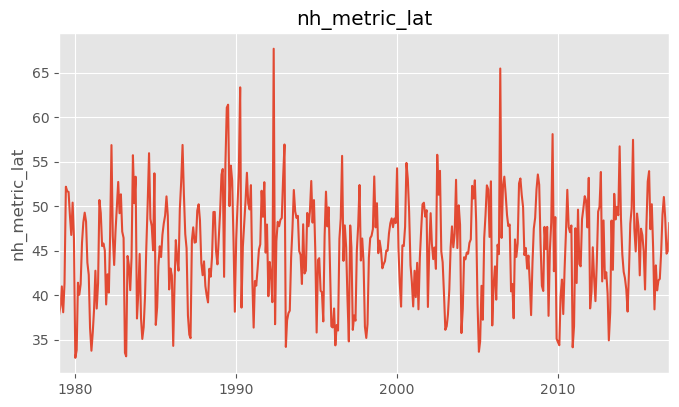

In [104]:
# 4. plot using an inbuild pygeode function that uses matplotlib libraries
fig, axes = plt.subplots()
ax = pyg.plot.AxesWrapper() 
pyg.showvar(edj_lats.nh_metric_lat, axes=ax, fig=fig)
plt.show()

The `pygeode` interface for `pytropd` returns a `Dataset` with two added variables.

The variables contains the metric latitudes for Northern (`nh_metric_lat`) and Southern (`sh_metric_lat`) hemispheres separately. If only one hemisphere of data is provided, only one hemisphere is returned.

There variables contain additional information about the details of how the metric are calculated. In this case the "peak" method (default) was used.

In [105]:
print(edj_lats.sh_metric_lat)

<Var 'sh_metric_lat'>:
  Shape:  (time)  (456)
  Axes:
    time <StandardTime>:  Jan , 1979 :: to Dec , 2016 :: (456 values)
  Attributes:
    long_name      : EDJ metric latitude                                        
    unit           : degrees                                                    
    method_used:   : peak                                                       
  Type:  Var (dtype="float64")


This dimension can be aggregated over to compare methods, as in the next example.

In [106]:
# convert monthly to annual
u_data_annualmean = u_data_new.yearlymean()

# iterate over methods
methods = ["core_peak", "adjusted_peak", "core_max", "adjusted_max"]

methods_axis = pyg.NamedAxis(values=np.arange(len(methods)), name='method', methods=methods)
print(methods_axis)

method <NamedAxis 'method'>:  0  to 3  (4 values)


In [107]:
stj_lat_different_methods = pyg.concatenate(
    [pyt.pyg_stj(u_data_annualmean, method=m).extend(2, methods_axis(method=i_m)) for i_m,m in enumerate(methods)])

Using lat in the dataset as the Latitude
Replacing pyg.NamedAxis lat with a pyg.Lat axis in the dataset
Found Pressure axis in the dataset
Using ua_yearly_mean in the dataset as the Zonal wind
Using lat in the dataset as the Latitude
Replacing pyg.NamedAxis lat with a pyg.Lat axis in the dataset
Found Pressure axis in the dataset
Using ua_yearly_mean in the dataset as the Zonal wind
Using lat in the dataset as the Latitude
Replacing pyg.NamedAxis lat with a pyg.Lat axis in the dataset
Found Pressure axis in the dataset
Using ua_yearly_mean in the dataset as the Zonal wind
Using lat in the dataset as the Latitude
Replacing pyg.NamedAxis lat with a pyg.Lat axis in the dataset
Found Pressure axis in the dataset
Using ua_yearly_mean in the dataset as the Zonal wind


In [108]:
print(stj_lat_different_methods)

<Dataset>:
Vars:
  sh_metric_lat (time,method)  (38,4)
  nh_metric_lat (time,method)  (38,4)
Axes:
  time <StandardTime>:   , 1979 :: to  , 2016 :: (38 values)
  method <NamedAxis 'method'>:  0  to 3  (4 values)
Global Attributes:
  long_name      : STJ metric latitude
  units          : degrees


In [109]:
methods[0]

'core_peak'

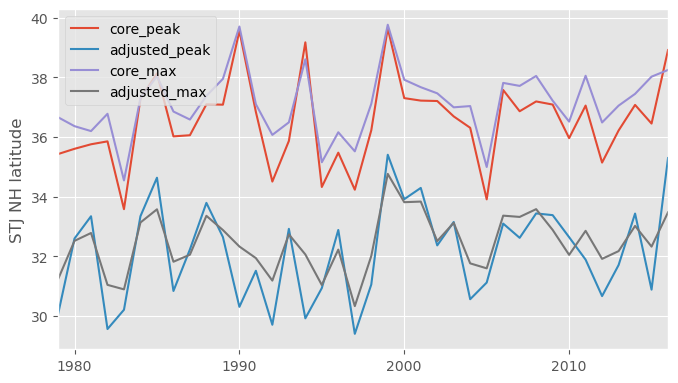

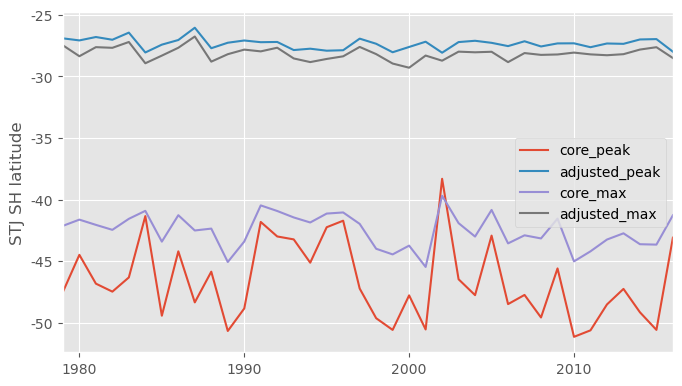

In [111]:
# 4. plot
fig, axes = plt.subplots(1,2)
ax = pyg.plot.AxesWrapper() 
plt.ioff()
for i in range(stj_lat_different_methods.method.size):
    pyg.showvar(stj_lat_different_methods.nh_metric_lat(method=i), label=methods[i], axes=ax, fig=fig)
ax.render(fig=fig)
plt.legend()
plt.ylabel("STJ NH latitude")
plt.title("")
plt.ion()
plt.show()

fig, axes = plt.subplots(2,2)
ax = pyg.plot.AxesWrapper() 
plt.ioff()
for i in range(stj_lat_different_methods.method.size):
    pyg.showvar(stj_lat_different_methods.sh_metric_lat(method=i), label=methods[i], axes=ax, fig=fig)
ax.render(fig=fig)
plt.legend()
plt.ylabel("STJ SH latitude")
plt.title("")
plt.ion()
plt.show()